# **Competition: Natural Language Processing with Disaster Tweets**

## **A. Thu thập dữ liệu**

Twitter đã trở thành một kênh liên lạc quan trọng trong trường hợp khẩn cấp.
Sự phổ biến của điện thoại thông minh cho phép mọi người thông báo trường hợp khẩn cấp mà họ đang quan sát thấy trong thời gian thực. Do đó, ngày càng có nhiều cơ quan quan tâm đến việc theo dõi Twitter theo chương trình (tức là các tổ chức cứu trợ thảm họa và hãng thông tấn).

Tuy nhiên, không phải lúc nào bài Tweet của một người cũng có thực sự thông báo về một thảm họa.

Ta cần xây dựng một mô hình máy học dự đoán Tweet nào nói về thảm họa thực sự và Tweet nào không.

Bộ dữ liệu được chia sẻ miễn phí trên nền tảng Kaggle (Link Kaggle: https://www.kaggle.com/competitions/nlp-getting-started/overview)

Tập dữ liệu này được tạo bởi công ty **figure-eight** và ban đầu được chia sẻ trên trang web <a rel="noreferrer nofollow" target="_blank" href="https://www.figure-eight.com/data-for-everyone/">‘Data For Everyone’ website here</a> .

Nguồn tweet: https://twitter.com/AnyOtherAnnaK/status/629195955506708480


## **B. Tiền xử ký và khám phá dữ liệu**

### **1 .Import các thư viện**

In [1]:
!pip install transformers datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 10.0 MB/s eta 0:00:00


In [2]:
!pip install wordcloud

In [3]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from scipy import stats
from collections import Counter

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import en_core_web_sm

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nlp = en_core_web_sm.load()

from transformers import set_seed
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, TrainingArguments, default_data_collator, Trainer
from datasets import Dataset
from datasets import load_metric

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **2. Đọc file dữ liệu vào dataframe**

In [4]:
warnings.filterwarnings("ignore")
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **3. Tiền xử lý dữ liệu**

**Số dòng** và **số cột** của bộ dữ liệu:

In [5]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  7613
Num cols:  5


**Ý nghĩa của mỗi dòng**: Thông tin về mỗi bài Tweet.

**Kiểm tra trùng lặp dữ liệu:**

In [6]:
sum(df.duplicated())

0

Không có dòng bị trùng lặp, ta không cần xử ký gì.

**Ý nghĩa của mỗi cột**:

- `id` : Mã định danh cho bài Tweet (Mỗi bài Tweet có mã khác nhau).
- `keyword` : Một từ khóa cụ thể từ tweet (có thể để trống).
- `location` : Vị trí gửi tweet từ đó (có thể để trống).
- `text`: Nội dung của tweet.
- `target` : Chỉ trong **train.csv** , điều này biểu thị liệu một tweet có phải là về một thảm họa thực sự (1) hay không( 0).

**Kiểu dữ liệu của mỗi cột:**

In [7]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Các cột đã có kiểu dữ liệu phù hợp.

**Phân bố giá trị của các cột numerical:**

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [8]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

In [9]:
df[numeric_cols].describe().round(2)

,id,target
count,7613.00,7613.00
mean,5441.93,0.43
std,3137.12,0.50
min,1.00,0.00
25%,2734.00,0.00
50%,5408.00,0.00
75%,8146.00,1.00
max,10873.00,1.00


**Phân bố giá trị của các cột categorical:**

In [10]:
df[set(df.columns)-set(numeric_cols)].describe()

,location,keyword,text
count,5080,7552,7613
unique,3341,221,7503
top,USA,fatalities,11-Year-Old Boy Charged With Manslaughter of T...
freq,104,45,10


**Kiểm tra giá trị bị thiếu:**

In [11]:
df.isnull().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

Các cột `location` và `keyword` có hiện tượng mất mác dữ liệu, trong đó `location` có tỷ lệ mất mác khá lớn. Tuy nhiên vì hai cột này và cột `id` không có tác dụng trong việc xây dựng mô hình sau này nên ta sẽ tiến hành loại bỏ chúng.

In [12]:
df = df.drop(columns=['id', 'keyword', 'location'])
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Qua kiểm tra ta thấy không có sự khác biệt lớn giữa hai lớp, điều này là tốt cho việc đào tạo mô hình.

**Tiền xử lý dữ liệu (cột text)**

Ta thử xem 1 giá trị trong cột `text` trước khi được tiền xử lý:

In [13]:
df['text'][23]

'What a wonderful day!'

Tiến hàng các bước tiền xử lý:

- **Chuyển viết hoa thành viết thường**

In [14]:
df['text'] = df['text'].apply(lambda x: x.lower())

- **Xóa các tag tên, hashtag trên bài tweet:**

In [15]:
df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+\s*', '', x))

df['text'] = df['text'].apply(lambda x: x.replace("#", ""))

- **Xóa URL's**

In [16]:
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

- **Xóa dấu câu**

In [17]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

- **Xóa chữ số**

In [18]:
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))

- **Xóa HTML Tags**

In [19]:
df['text'] = df['text'].apply(lambda x : re.compile(r'<.*?>').sub(r'', x))

Giá trị ở trên sau khi thực hiện các bước tiền xử lý.

In [20]:
df['text'][23]

'what a wonderful day'

Bây giờ ta sẽ tạo thêm cột tokens - là một vector, mỗi token chứa các word của mỗi bài Tweet và quay lại tiếp tục "Khám phá dữ liệu".

In [21]:
df['tokens'] = df['text'].apply(word_tokenize)
df.head()

,text,target,tokens
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala..."


### **4. Khám phá dữ liệu:**

**Phân phối của cột target**

In [22]:
target_counts = df['target'].value_counts()
target_counts

0    4342
1    3271
Name: target, dtype: int64

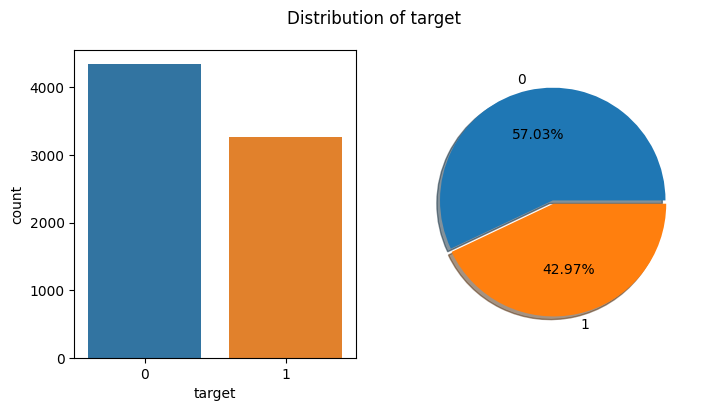

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.countplot(data=df, x='target', ax=axes[0])

axes[1].pie(target_counts,
            labels=target_counts.index,
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.03, 0))

fig.suptitle('Distribution of target')
plt.show()

**Số ký tự trong mỗi Tweet**

Chúng ta sẽ xem xét xem liệu "số ký tự trong mỗi Tweet" có ảnh hưởng đến nhãn của Tweet đó không. Hay nói cách khác là: Sự khác nhau về "số ký tự" giữa Tweet thảm họa và Tweet không thảm họa.

In [24]:
df['character_number'] = df['text'].str.len()
df.head()

,text,target,tokens,character_number
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86


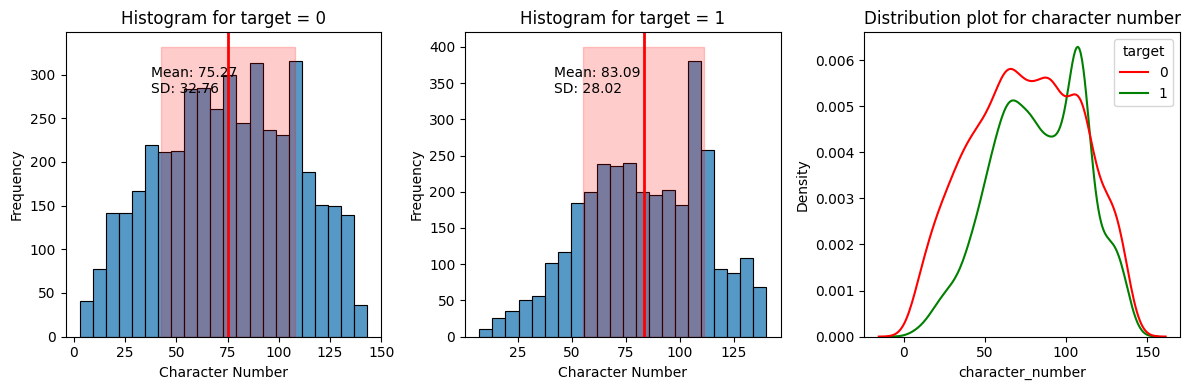

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(2):
    character_number_i = df[df['target'] == i]['character_number']
    mean_i = character_number_i.mean()
    std_i = character_number_i.std()

    sns.histplot(character_number_i, ax=axes[i])
    axes[i].axvline(mean_i, color='red', linewidth=2)
    axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], mean_i - std_i, mean_i + std_i, color='red', alpha=0.2)
    axes[i].annotate(f'Mean: {mean_i:.2f}\nSD: {std_i:.2f}', xy=(mean_i*0.5, axes[i].get_ylim()[1]*0.8))
    axes[i].set_title(f"Histogram for target = {i}")
    axes[i].set_xlabel('Character Number')
    axes[i].set_ylabel('Frequency')

sns.kdeplot(data=df, x='character_number', hue='target', palette=['red', 'green'], ax=axes[2])
axes[2].set_title('Distribution plot for character number')

plt.tight_layout()
plt.show()

Từ Histogram ta thấy trung bình "số ký tự" của Tweet không thảm họa nhỏ hơn so với Tweet thảm họa. Tuy nhiên, từ biểu đồ Distribution ta lại thấy các Tweet không thảm họa có "số ký tự" lớn hơn các Tweet thảm họa. Vậy các Tweet không thảm họa "dài hơn" các Tweet thảm họa không?

Để trả lời cho câu hỏi trên, ta sẽ tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các Tweet không thảm họa không dài hơn các Tweet thảm họa"} \\
H_1: \text{"Các Tweet không thảm họa dài hơn các Tweet thảm họa"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [26]:
t_statistic, p_value = stats.ttest_ind(df[df['target'] == 1]['character_number'], df[df['target'] == 0]['character_number'], alternative="greater")

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  10.956243793749957
p-value =  4.992396542423331e-28
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Vậy ta có thể kết luận: "Các Tweet không thảm họa dài hơn các Tweet thảm họa" với độ tin cậy 95%.

**Số từ trong mỗi Tweet**

Chúng ta sẽ xem xét xem liệu "số từ trong mỗi Tweet" có ảnh hưởng đến nhãn của Tweet đó không. Hãy nói cách khác là: Sự khác nhau về "số từ" giữa Tweet thảm họa và Tweet không thảm họa.

In [27]:
df['word_number'] = df['tokens'].apply(lambda x: len(x))
df.head()

,text,target,tokens,character_number,word_number
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16


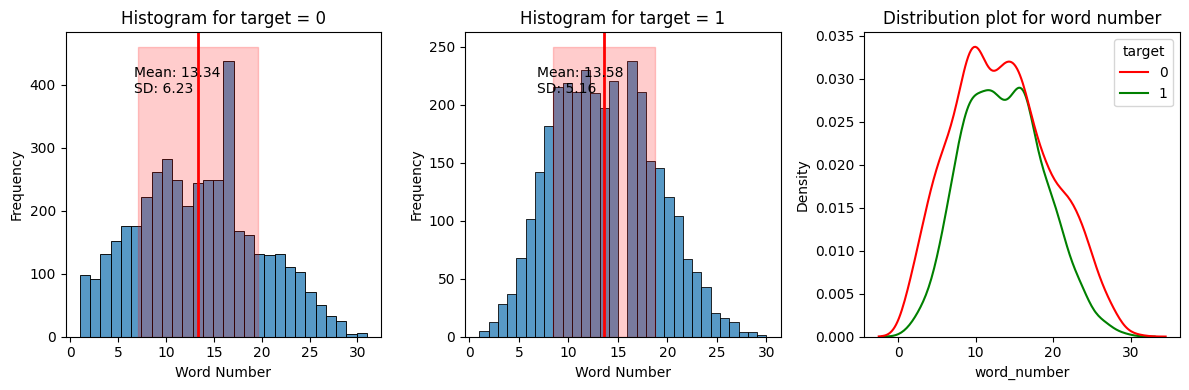

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(2):
    word_number_i = df[df['target'] == i]['word_number']
    mean_i = word_number_i.mean()
    std_i = word_number_i.std()

    sns.histplot(word_number_i, ax=axes[i])
    axes[i].axvline(mean_i, color='red', linewidth=2)
    axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], mean_i - std_i, mean_i + std_i, color='red', alpha=0.2)
    axes[i].annotate(f'Mean: {mean_i:.2f}\nSD: {std_i:.2f}', xy=(mean_i*0.5, axes[i].get_ylim()[1]*0.8))
    axes[i].set_title(f"Histogram for target = {i}")
    axes[i].set_xlabel('Word Number')
    axes[i].set_ylabel('Frequency')

sns.kdeplot(data=df, x='word_number', hue='target', palette=['red', 'green'], ax=axes[2])
axes[2].set_title('Distribution plot for word number')

plt.tight_layout()
plt.show()

Từ Histogram ta thấy trung bình "số từ" của Tweet không thảm họa và Tweet thảm họa không chênh lệch nhiều. Tuy nhiên, từ biểu đồ Distribution ta lại thấy các Tweet không thảm họa luôn có "số từ" nhiều hơn các Tweet thảm họa. Vậy các Tweet không thảm họa có số từ nhiều hơn các Tweet thảm họa không?

Để trả lời cho câu hỏi trên, ta sẽ tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các Tweet không thảm họa có số từ không nhiều hơn các Tweet thảm họa"} \\
H_1: \text{"Các Tweet không thảm họa có số từ nhiều hơn các Tweet thảm họa"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [29]:
t_statistic, p_value = stats.ttest_ind(df[df['target'] == 1]['word_number'], df[df['target'] == 0]['word_number'], alternative="greater")

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  1.7814083658997426
p-value =  0.03744281408676793
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Vậy ta có thể kết luận: "Các Tweet không thảm họa có số từ nhiều hơn các Tweet thảm họa" với mức ý nghĩa 0.95.

**Độ dài trung bình của từ trong mỗi Tweet**

Chúng ta sẽ xem xét xem liệu "độ dài trung bình của từ trong mỗi Tweet" có ảnh hưởng đến nhãn của Tweet đó không. Hãy nói cách khác là: Sự khác nhau về "độ dài trung bình của từ" giữa Tweet thảm họa và Tweet không thảm họa.

In [30]:
df['average_word_length'] = df['tokens'].apply(lambda x: np.mean([len(i) for i in x]))
df.head()

,text,target,tokens,character_number,word_number,average_word_length
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000


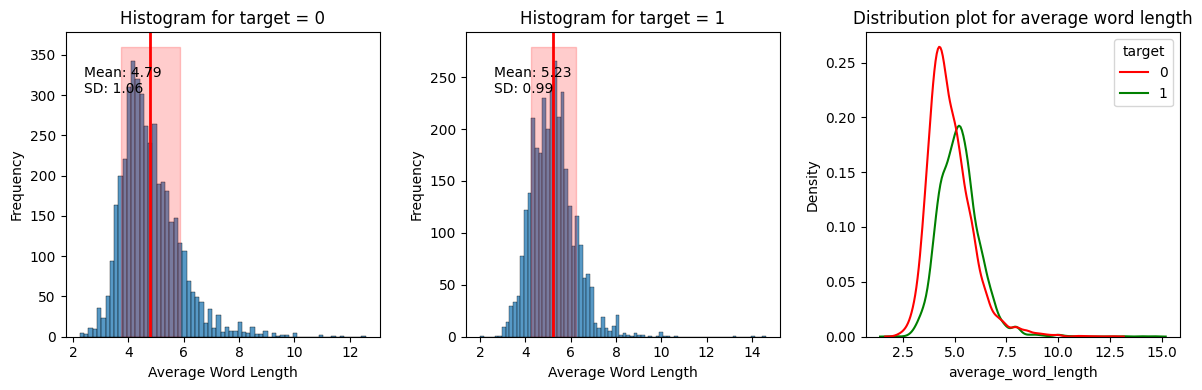

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(2):
    average_word_length_i = df[df['target'] == i]['average_word_length']
    mean_i = average_word_length_i.mean()
    std_i = average_word_length_i.std()

    sns.histplot(average_word_length_i, ax=axes[i])
    axes[i].axvline(mean_i, color='red', linewidth=2)
    axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], mean_i - std_i, mean_i + std_i, color='red', alpha=0.2)
    axes[i].annotate(f'Mean: {mean_i:.2f}\nSD: {std_i:.2f}', xy=(mean_i*0.5, axes[i].get_ylim()[1]*0.8))
    axes[i].set_title(f"Histogram for target = {i}")
    axes[i].set_xlabel('Average Word Length')
    axes[i].set_ylabel('Frequency')

sns.kdeplot(data=df, x='average_word_length', hue='target', palette=['red', 'green'], ax=axes[2])
axes[2].set_title('Distribution plot for average word length')

plt.tight_layout()
plt.show()

Từ Histogram ta thấy trung bình "độ dài trung bình từ" của Tweet không thảm họa và Tweet thảm họa không chênh lệch nhiều. Tuy nhiên, từ biểu đồ Distribution ta lại thấy các Tweet không thảm họa có "độ dài trung bình từ" lớn hơn các Tweet thảm họa một chút. Vậy các Tweet không thảm họa có độ dài trung bình từ lớn hơn các Tweet thảm họa không?

Để trả lời cho câu hỏi trên, ta sẽ tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các Tweet không thảm họa có độ dài trung bình từ không lớn hơn các Tweet thảm họa"} \\
H_1: \text{"Các Tweet không thảm họa có độ dài trung bình từ lớn hơn các Tweet thảm họa"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [32]:
t_statistic, p_value = stats.ttest_ind(df[df['target'] == 1]['average_word_length'], df[df['target'] == 0]['average_word_length'], alternative="greater")

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  18.577274798952068
p-value =  1.1191422338174247e-75
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


Vậy ta có thể kết luận: "Các Tweet không thảm họa có độ dài trung bình từ lớn hơn các Tweet thảm họa" với độ tin cậy 95%.

**Số động từ trong mỗi Tweet**

Chúng ta sẽ xem xét xem liệu "số động từ trong mỗi Tweet" có ảnh hưởng đến nhãn của Tweet đó không. Hãy nói cách khác là: Sự khác nhau về "số động từ" giữa Tweet thảm họa và Tweet không thảm họa.

In [33]:
df['number_verbs'] = df['tokens'].apply(lambda x: sum(1 for word, pos in pos_tag(x) if pos.startswith('VB')))
df.head()

,text,target,tokens,character_number,word_number,average_word_length,number_verbs
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692,2
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571,0
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545,7
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857,1
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000,3


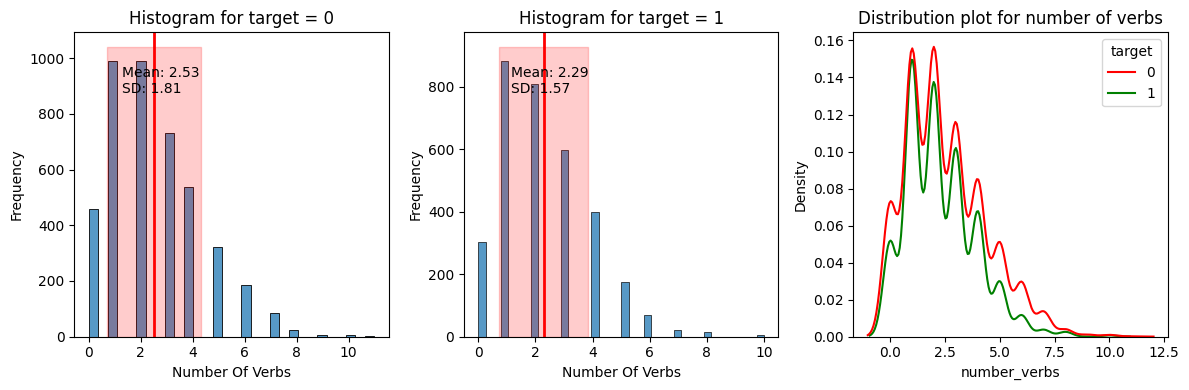

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(2):
    number_verbs_i = df[df['target'] == i]['number_verbs']
    mean_i = number_verbs_i.mean()
    std_i = number_verbs_i.std()

    sns.histplot(number_verbs_i, ax=axes[i])
    axes[i].axvline(mean_i, color='red', linewidth=2)
    axes[i].fill_betweenx([0, axes[i].get_ylim()[1]], mean_i - std_i, mean_i + std_i, color='red', alpha=0.2)
    axes[i].annotate(f'Mean: {mean_i:.2f}\nSD: {std_i:.2f}', xy=(mean_i*0.5, axes[i].get_ylim()[1]*0.8))
    axes[i].set_title(f"Histogram for target = {i}")
    axes[i].set_xlabel('Number Of Verbs')
    axes[i].set_ylabel('Frequency')

sns.kdeplot(data=df, x='number_verbs', hue='target', palette=['red', 'green'], ax=axes[2])
axes[2].set_title('Distribution plot for number of verbs')

plt.tight_layout()
plt.show()

Từ Histogram ta thấy trung bình "số động từ" của Tweet không thảm họa và Tweet thảm họa không chênh lệch nhiều. Tuy nhiên, từ biểu đồ Distribution ta lại thấy các Tweet không thảm họa có "số động từ" nhiều hơn các Tweet thảm họa một chút. Vậy các Tweet không thảm họa có số động từ nhiều hơn các Tweet thảm họa không?

Để trả lời cho câu hỏi trên, ta sẽ tiến hành kiểm định giả thuyết sau:

\begin{cases}
H_0: \text{"Các Tweet không thảm họa có số động từ không nhiều hơn các Tweet thảm họa"} \\
H_1: \text{"Các Tweet không thảm họa có số động từ nhiều hơn các Tweet thảm họa"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [35]:
t_statistic, p_value = stats.ttest_ind(df[df['target'] == 1]['number_verbs'], df[df['target'] == 0]['number_verbs'], alternative="greater")

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  -6.159138512938877
p-value =  0.9999999996157057
Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa 0.05


Vậy ta không thể kết luận: "Các Tweet không thảm họa có số động từ nhiều hơn các Tweet thảm họa" với mức ý nghĩa 0.05.

### **Loại bỏ stop words**

**Stop words là gì?**

Stop words (từ dừng) là một thuật ngữ trong xử lý ngôn ngữ tự nhiên để chỉ các từ thông thường, phổ biến và không mang nhiều ý nghĩa đặc biệt trong một ngôn ngữ nhất định.

Ví dụ về các stop words trong tiếng Anh bao gồm "a", "an", "the", "in", "on", "is", "are", "and", "but", "of", "to" và nhiều từ khác. Những từ này thường xuất hiện rất phổ biến trong văn bản nhưng không mang nhiều ý nghĩa cụ thể và thường không đóng góp vào việc hiểu nghĩa của văn bản.

Loại bỏ các từ dừng khỏi văn bản có thể giúp tăng cường hiệu quả xử lý ngôn ngữ bằng cách giảm kích thước của văn bản, cải thiện tốc độ xử lý và giảm nhiễu không cần thiết trong dữ liệu.

Tuy nhiên, việc loại bỏ stop words không phải lúc nào cũng là lựa chọn tốt. Trong một số trường hợp, stop words có thể mang thông tin quan trọng như trong việc phân tích ngữ cảnh hoặc xác định cấu trúc câu.

Do đó, ta sẽ tạo thêm một cột để lưu các Tweet sau khi đã loại bỏ stop words.

In [36]:
stop_words = stopwords.words('english')

df['removed_stop_words'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,text,target,tokens,character_number,word_number,average_word_length,number_verbs,removed_stop_words
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692,2,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571,0,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545,7,"[residents, asked, shelter, place, notified, o..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857,1,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000,3,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


Sau khi loại bỏ `stop word` ta sẽ tiếp tục phân tích dữ liệu:

**Unigrams phổ biến nhất**

Unigrams là các đơn vị từ ngữ đơn lẻ trong văn bản. Mỗi từ được coi là một unigram. Ví dụ, trong câu "This is a cat", các unigram là "This", "is", "a", và "cat". Unigrams không liên kết với nhau theo thứ tự hoặc bối cảnh trong văn bản, chúng chỉ là các thành phần cơ bản để tạo thành câu hoặc văn bản.

Ta sẽ xem top 20 số lượng unigrams nhiều nhất theo 2 loại Tweet là không phải thảm họa và thảm họa

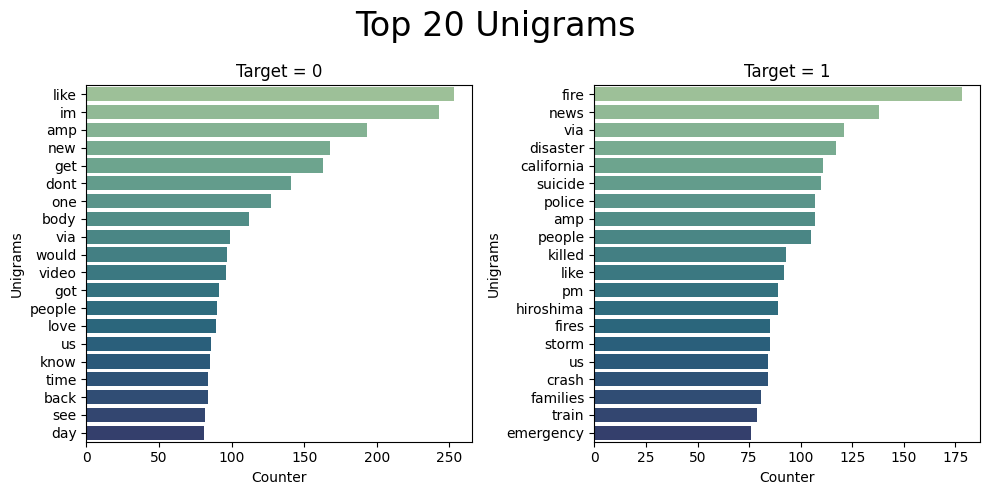

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i in range(2):
    removed_stop_words_i = df[df['target'] == i]['removed_stop_words']
    top_unigrams_i = pd.DataFrame(Counter(removed_stop_words_i.sum()).most_common(20), columns=['Unigrams', 'Counter'])

    sns.barplot(data = top_unigrams_i, x = 'Counter', y = 'Unigrams', palette='crest', ax=axes[i])
    axes[i].set_title(f"Target = {i}")

fig.suptitle('Top 20 Unigrams', fontsize=24)
plt.tight_layout()
plt.show()

Ta thấy có sự khác biệt rõ ràng giữa Unigrams của Tweet không thảm họa và Tweet thảm họa. Nếu Unigrams của Tweet không thảm họa là những từ chung chung thì bên Tweet thảm họa là những từ như: fire(hỏa hoạn), news(tin tức), disaster(thảm họa), suicide(tự sát), police(cảnh sát), killed(giết), ...

Nhận xét trên sẽ được trực quan bằng biểu đồ Word-Cloud dưới đây

In [38]:
from wordcloud import WordCloud

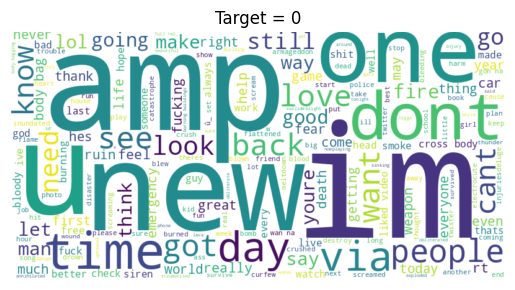

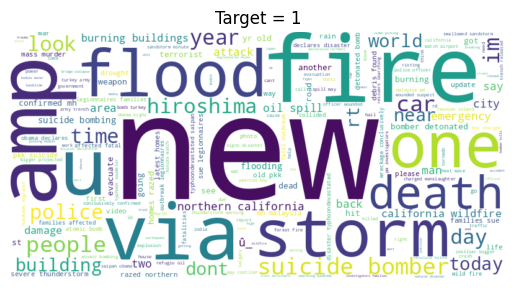

In [39]:
for i in range(2):
    removed_stop_words_i = df[df['target'] == i]['removed_stop_words']
    all_words=removed_stop_words_i.sum()
    text = ' '.join(all_words)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    #plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Target = {i}")
    plt.show()


**Bigrams phổ biến nhất**

Bigrams là cặp từ liên tiếp nhau trong văn bản. Mỗi bigram bao gồm hai từ liên tiếp nhau theo thứ tự. Ví dụ, trong câu "This is a cat", các bigrams là "This is", "is a", và "a cat". Bigrams cho phép xem xét thông tin về sự tương quan và sự kết hợp giữa các từ trong văn bản, các cặp từ có quan hệ với nhau sẽ thường xuất hiện cùng nhau. Các bigrams có thể cung cấp thông tin về cấu trúc câu, ngữ cảnh và ý nghĩa của văn bản.

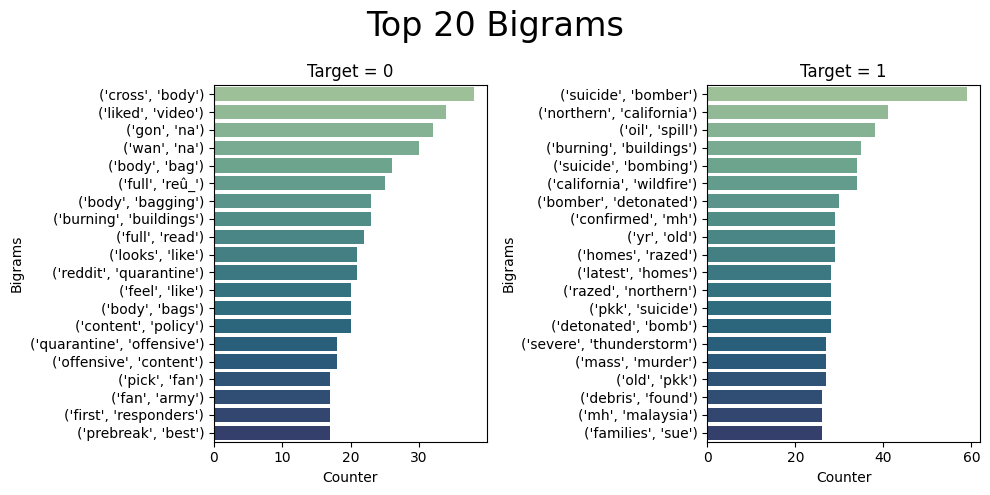

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i in range(2):
    removed_stop_words_i = df[df['target'] == i]['removed_stop_words']
    bigrams_i = removed_stop_words_i.apply(lambda x: list(ngrams(x, 2)))
    top_bigrams_i = pd.DataFrame(Counter(bigrams_i.sum()).most_common(20), columns=['Bigrams', 'Counter'])

    sns.barplot(data = top_bigrams_i, x = 'Counter', y = 'Bigrams', palette='crest', ax=axes[i])
    axes[i].set_title(f"Target = {i}")

fig.suptitle('Top 20 Bigrams', fontsize=24)
plt.tight_layout()
plt.show()

Vẫn có sự khác biệt giữa Bigrams của Tweet không thảm họa và Tweet thảm họa. Từ các cặp từ xuất hiện cùng nhau của Tweet thảm họa, ta có thể phỏng đoán được về các sự kiện về tai nạn, thảm hoạ xảy ra: suicide bomber(đánh bom tự sát), burning buildings(tòa nhà cháy), oil spill(tràn dầu), california wildfire(cháy rừng california), ...

**Named Entity phổ biến nhất**

Named Entity là một thuật ngữ trong xử lý ngôn ngữ tự nhiên để chỉ các đối tượng, người, địa điểm, tổ chức hoặc thông tin có ý nghĩa trong văn bản. Các Named Entity là các thành phần quan trọng(key word) trong việc trích xuất thông tin và truy vấn thông tin từ văn bản.

Ví dụ về các loại Named Entity bao gồm:

* Người: Barack Obama, Steve Jobs, Albert Einstein
* Địa điểm: Paris, London, Đại dương Thái Bình Dương
* Tổ chức: Microsoft, Google, Liên hợp quốc
* Thời gian: ngày 20 tháng 1 năm 2022, thế kỷ 21
* Sản phẩm: iPhone, Toyota Camry, Coca-Cola

Ta hãy xem các Named Entity của hai loại Tweet có cung cấp giá trị gì về thông tin để phân biệt giữa hai loại Tweet này hay không.

In [41]:
df['named_entity'] = df['text'].apply(lambda row: [ent.label_ for ent in nlp(row).ents])
df.head()

,text,target,tokens,character_number,word_number,average_word_length,number_verbs,removed_stop_words,named_entity
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692,2,"[deeds, reason, earthquake, may, allah, forgiv...",[]
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571,0,"[forest, fire, near, la, ronge, sask, canada]",[GPE]
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545,7,"[residents, asked, shelter, place, notified, o...",[]
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857,1,"[people, receive, wildfires, evacuation, order...",[GPE]
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000,3,"[got, sent, photo, ruby, alaska, smoke, wildfi...",[]


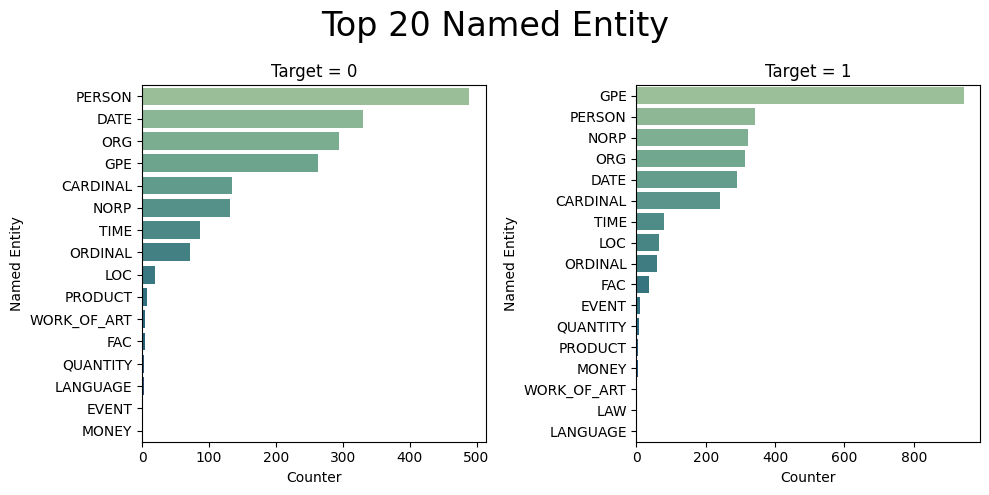

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i in range(2):
    named_entity_i = df[df['target'] == i]['named_entity']
    top_bigrams_i = pd.DataFrame(Counter(named_entity_i.sum()).most_common(20), columns=['Named Entity', 'Counter'])

    sns.barplot(data = top_bigrams_i, x = 'Counter', y = 'Named Entity', palette='crest', ax=axes[i])
    axes[i].set_title(f"Target = {i}")

fig.suptitle('Top 20 Named Entity', fontsize=24)
plt.tight_layout()
plt.show()

Không có khác biệt quá lớn giữa Named Entity của Tweet không thảm họa và Tweet thảm họa. Về cơ bản, những Named Entity xuất hiện ở Tweet không thảm họa cũng xuất hiện ở Tweet thảm họa.

Có lẽ ta không thu được nhiều thông tin giá trị từ các Named Entity này.

## **C. Xây dựng mô hình**

### **1. Chuẩn bị dữ liệu**

**Tiến trình xử lý dữ liệu: text => input_ids**

Sử dụng gói thư viện Transformers để tạo ra một tokenizer cho mô hình BERT.

Tokenizer này sẽ được sử dụng để chia văn bản thành các đơn vị nhỏ hơn và chuyển đổi chúng thành các chỉ số tương ứng để đưa vào mô hình BERT xử lý.

In [43]:
# Khởi tạo bộ sinh số ngẫu nhiên
set_seed(2023)

In [44]:
# Tạo ra một tokenizer từ mô hình  với phiên bản "bert-large-uncased" cho quá trình chia văn bản
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

Ví dụ quá trình ánh xạ câu văn bản thành các token_id:

In [45]:
# Câu văn bản gốc
print(' Original: ', df['text'][100])

# Câu văn bản sau khi được chia nhỏ vào tokens.
print('Tokenized: ', tokenizer.tokenize(df['text'][100]))

# Câu văn bản sau khi được ánh xạ tới các token_id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['text'][100])))

 Original:  bahrain police had previously died in a road accident they were not killed by explosion 
Tokenized:  ['bahrain', 'police', 'had', 'previously', 'died', 'in', 'a', 'road', 'accident', 'they', 'were', 'not', 'killed', 'by', 'explosion']
Token IDs:  [15195, 2610, 2018, 3130, 2351, 1999, 1037, 2346, 4926, 2027, 2020, 2025, 2730, 2011, 7738]


Ta tìm độ dài lớn nhất của một tweet để thuận tiện cho việc thiết lập độ dài cho tokenizer.

In [46]:
# Tính độ dài của mỗi chuỗi văn bản trong cột 'text' bằng cách chia chuỗi thành các từ riêng biệt và đếm số từ.
# Kết quả này được lưu vào cột 'text_lengths'.
df['text_lengths'] = df['text'].apply(lambda x: len(x.split()))

# Tìm giá trị độ dài từ dài nhất và ngắn nhất trong cột 'text_lengths'
max_word_length = df['text_lengths'].max()
min_word_length = df['text_lengths'].min()

# Xóa cột 'text_lengths' sau khi đã tìm được độ dài từ dài nhất và ngắn nhất
df.drop('text_lengths', axis=1, inplace=True)

# In kết quả
print("Maximum word length:", max_word_length)
print("Minimum word length:", min_word_length)

Maximum word length: 31
Minimum word length: 1


 Giới hạn ký tự trong một tweet là 280 ký tự, ta lấy trung bình một từ tiếng Anh có 5 ký tự thì sẽ có tối đa 56 từ.

Chuyển đổi các chuỗi văn bản (cột text) thành token:

In [47]:
# Độ dài tối đa của chuỗi đầu ra sau khi được mã hóa
max_word_length=60

df['input_ids']=df['text'].apply(lambda x: tokenizer(x, max_length=max_word_length, padding='max_length')['input_ids'])

df.head(n=10)

,text,target,tokens,character_number,word_number,average_word_length,number_verbs,removed_stop_words,named_entity,input_ids
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692,2,"[deeds, reason, earthquake, may, allah, forgiv...",[],"[101, 2256, 15616, 2024, 1996, 3114, 1997, 202..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571,0,"[forest, fire, near, la, ronge, sask, canada]",[GPE],"[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187..."
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545,7,"[residents, asked, shelter, place, notified, o...",[],"[101, 2035, 3901, 2356, 2000, 7713, 1999, 2173..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857,1,"[people, receive, wildfires, evacuation, order...",[GPE],"[101, 2111, 4374, 3748, 26332, 13982, 4449, 19..."
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000,3,"[got, sent, photo, ruby, alaska, smoke, wildfi...",[],"[101, 2074, 2288, 2741, 2023, 6302, 2013, 1009..."
5,rockyfire update california hwy closed in bo...,1,"[rockyfire, update, california, hwy, closed, i...",101,15,5.600000,2,"[rockyfire, update, california, hwy, closed, d...","[GPE, GPE]","[101, 6857, 10273, 10651, 2662, 1044, 18418, 2..."
6,flood disaster heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ...",92,14,5.642857,1,"[flood, disaster, heavy, rain, causes, flash, ...",[GPE],"[101, 7186, 7071, 3082, 4542, 5320, 5956, 9451..."
7,im on top of the hill and i can see a fire in ...,1,"[im, on, top, of, the, hill, and, i, can, see,...",55,15,2.733333,1,"[im, top, hill, see, fire, woods]",[],"[101, 10047, 2006, 2327, 1997, 1996, 2940, 199..."
8,theres an emergency evacuation happening now i...,1,"[theres, an, emergency, evacuation, happening,...",78,12,5.583333,1,"[theres, emergency, evacuation, happening, bui...",[],"[101, 2045, 2015, 2019, 5057, 13982, 6230, 208..."
9,im afraid that the tornado is coming to our area,1,"[im, afraid, that, the, tornado, is, coming, t...",48,10,3.900000,2,"[im, afraid, tornado, coming, area]",[],"[101, 10047, 4452, 2008, 1996, 11352, 2003, 27..."


Thực hiện việc đổi tên cột `target` thành `labels` trong dataframe df.

Điều này thường được sử dụng khi áp dụng mô hình BertForSequenceClassification, trong đó tên cột chứa nhãn `target` của dữ liệu được yêu cầu phải là `labels`.

In [48]:
df.rename(columns={'target':'labels'}, inplace=True)
df.head()

,text,labels,tokens,character_number,word_number,average_word_length,number_verbs,removed_stop_words,named_entity,input_ids
0,our deeds are the reason of this earthquake ma...,1,"[our, deeds, are, the, reason, of, this, earth...",68,13,4.307692,2,"[deeds, reason, earthquake, may, allah, forgiv...",[],"[101, 2256, 15616, 2024, 1996, 3114, 1997, 202..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",37,7,4.428571,0,"[forest, fire, near, la, ronge, sask, canada]",[GPE],"[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187..."
2,all residents asked to shelter in place are be...,1,"[all, residents, asked, to, shelter, in, place...",130,22,4.954545,7,"[residents, asked, shelter, place, notified, o...",[],"[101, 2035, 3901, 2356, 2000, 7713, 1999, 2173..."
3,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...",58,7,7.142857,1,"[people, receive, wildfires, evacuation, order...",[GPE],"[101, 2111, 4374, 3748, 26332, 13982, 4449, 19..."
4,just got sent this photo from ruby alaska as s...,1,"[just, got, sent, this, photo, from, ruby, ala...",86,16,4.375000,3,"[got, sent, photo, ruby, alaska, smoke, wildfi...",[],"[101, 2074, 2288, 2741, 2023, 6302, 2013, 1009..."


Ta chỉ giữ lại hai cột quan trọng (input_ids, labels) cho việc huấn luyện mô hình và giảm bớt dữ liệu không cần thiết.

In [49]:
df = df[['input_ids', 'labels']]
df.head()

,input_ids,labels
0,"[101, 2256, 15616, 2024, 1996, 3114, 1997, 202...",1
1,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...",1
2,"[101, 2035, 3901, 2356, 2000, 7713, 1999, 2173...",1
3,"[101, 2111, 4374, 3748, 26332, 13982, 4449, 19...",1
4,"[101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...",1


### **2. Chia tập dữ liệu:**

Thực hiện việc chia dữ liệu từ dataframe df thành hai phần:
- train_df: chứa phần lớn dữ liệu dùng để huấn luyện mô hình
- test_df: chứa một tỷ lệ nhỏ dữ liệu dùng để kiểm tra mô hình sau khi huấn luyện.

In [50]:
train_df = df[:-int(len(df)*0.005)].reset_index(drop=True)
test_df = df[-int(len(df)*0.005):].reset_index(drop=True)

In [51]:
print("Số dòng tập train:",len(train_df))
print("Số dòng tập test:",len(test_df))

Số dòng tập train: 7575
Số dòng tập test: 38


Chuyển đổi train_df và test_train từ dataframe sang định dạng dataset để sử dụng trong việc huấn luyện mô hình BERT

In [52]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [53]:
# In dataset huấn luyện
train_ds

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 7575
})

### **3. Xây dựng mô hình:**

![Image](https://phamdinhkhanh.github.io/assets/images/20200523_BERTModel/pic1.png)

**Giới thiệu về mô hình BERT-large**

Mô hình **BERT-large** (gồm 24 block sub-layers trong transformer)

Mô hình này được thiết kế để thực hiện tác vụ phân loại chuỗi văn bản, tức là đưa ra dự đoán cho mỗi chuỗi văn bản đầu vào thuộc vào một số lớp đã xác định trước

In [54]:
model = BertForSequenceClassification.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

**Thiết lập các tham số và cấu hình huấn luyện của lớp TrainingArguments từ thư viện transformers.**

Các tham số được thiết lập bao gồm: tên thư mục lưu trữ kết quả huấn luyện, chiến lược đánh giá, chiến lược lưu trữ kết quả, learning rate, số epoch, batch size, và các tham số khác.

In [55]:
batch_size = 16

args = TrainingArguments(
    'nlp-getting-started',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate=2e-5,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    warmup_ratio=0.1,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
)

**Tạo đối tượng data_collator**

Đối tượng data_collator được tạo từ hàm default_data_collator để tự động tạo batch và xử lý dữ liệu đầu vào cho quá trình huấn luyện và đánh giá.

In [56]:
data_collator = default_data_collator

**Tạo đối tượng trainer**

Đối tượng trainer của lớp Trainer được tạo từ thư viện transformers, đối tượng này sẽ quản lý quá trình huấn luyện mô hình.

Các tham số bao gồm: mô hình, cấu hình huấn luyện, dataset huấn luyện và dataset đánh giá, data collator, và tokenizer.

In [57]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

**Bắt đầu huấn luyện mô hình**

In [58]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,No log,0.163096
1,No log,0.111456
2,No log,0.078038


TrainOutput(global_step=177, training_loss=0.4207492979232874, metrics={'train_runtime': 874.8751, 'train_samples_per_second': 25.975, 'train_steps_per_second': 0.202, 'total_flos': 2472311976916320.0, 'train_loss': 0.4207492979232874, 'epoch': 2.99})

### **4. Đánh giá mô hình**

Định nghĩa một số hàm để tính toán các độ đo đánh giá (metrics) cho mô hình.

In [59]:
# Hàm đánh giá độ chính xác
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Đánh giá mô hình dựa trên tập dữ liệu kiểm tra (test_ds) và tính toán các độ đo đánh giá bằng cách sử dụng hàm compute_metrics đã được định nghĩa trước đó.

In [60]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

{'eval_loss': 0.078038290143013,
 'eval_accuracy': 0.9736842105263158,
 'eval_runtime': 0.7315,
 'eval_samples_per_second': 51.948,
 'eval_steps_per_second': 4.101}

`eval_loss`: 0.078038290143013,

`eval_accuracy`: 0.9736842105263158

Mô hình BERT đã xây dựng cho kết quả đánh giá tốt với độ mất mát thấp, độ chính xác cao và khả năng tính toán hiệu quả.

### **5. Xuất Model ra file:**

In [61]:
import pickle

Dự đoán trên một biến dữ liệu `text`

Để chuẩn bị dữ liệu cho dự đoán, ta cũng tiến hành xử lý dữ liệu tương tự như với tập dữ liệu **train.csv**
- Định dạng lại dữ liệu trên cột 'text'.
- Ánh xạ dữ liệu của cột 'text' vào các token_ids và lưu vào cột 'input_ids'.
- Giữ lại cột 'input_ids' cho việc huấn luyện dữ liệu và giảm chi phí với các dữ liệu không cần thiết.
- Chuyển dữ liệu từ dataframe sang dataset.

Định dạng lại dữ liệu trên biến 'text'

In [62]:
def preprocessing_data(text, tokenizer, max_word_length):

    df=pd.DataFrame.from_dict({'text' : [text]})

    df['text']=df['text'].apply(lambda x: x.lower())
    df['text']=df['text'].apply(lambda x: x.replace("#", ""))
    df['text']=df['text'].apply(lambda x: re.sub(r'@\w+\s*', '', x))
    df['text']=df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))
    df['text']=df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df['text']=df['text'].apply(lambda x: re.sub(r'\d+', '', x))
    df['text']=df['text'].apply(lambda x : re.compile(r'<.*?>').sub(r'', x))

    df['input_ids']=df['text'].apply(lambda x: tokenizer(x, max_length=max_word_length, padding='max_length')['input_ids'])
    df=df[['input_ids']]

    return Dataset.from_pandas(df)


In [63]:
preprocessing_data(text, tokenizer, max_word_length)

Dataset({
    features: ['input_ids'],
    num_rows: 1
})

In [64]:
data = {
    'tokenizer': tokenizer,
    'max_word_length': max_word_length,
    'model': model,
    #'preprocessing_data': preprocessing_data,
    'args': args,
}

In [65]:
with open('bert_model.pkl', 'wb') as f:
    pickle.dump(data, f)

_____________________________________________

In [66]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [67]:
#!cp -r '/content/bert_model.pkl' /content/gdrive/MyDrive/

## **D. Tài liệu tham khảo:**

[1]. https://www.kaggle.com/code/canamika27/disasater-tweet-classification/notebook